# FML - Winter Semester 2024

# Bonus Points Assignment 2

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0</div>
For detailed task instructions, please refer to the assignment PDF.

This assignment requires `numpy`, `matplotlib`, `tqdm`, and `torch` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment. If the problem persists, please seek help on the forums or use [the JupyterHub profile of the lecture](https://jupyter.rwth-aachen.de/hub/spawn).

In [22]:
from IPython.display import clear_output

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

from pathlib import Path
ROOT = Path().resolve()

# This contains the path to the data / folder of the assignment
# DO NOT change the path to the data. Only use data and dump files at this location.
DATA = ROOT / 'data'
EXAMPLE_IMAGE = DATA / 'example_image.png'

CHECKS_PASSED_MESSAGE = 'Great! All checks were passed.'

Run the next cell to check that all files are at the correct location. Do not change the location of the files.

In [23]:
assert EXAMPLE_IMAGE.exists(), f"Training data is missing."

## Linear Layers
All individual operations, including activation functions, will be represented as layers in this model.
The abstract `Layer` interface defines three methods. Make yourself familiar with the `Layer` class and its methods. You don't have to implement anything here. Simply run the cell below.

In [24]:
from abc import ABC, abstractmethod

class Layer(ABC):
    def __init__(self):
        """ Initializes the layer.
        
        Please DON'T change the names of the variables that are already defined in this method.
        """
        self.input = None  # during every forward pass, we will later store the inputs to that forward pass
        self.output = None  # during every forward pass, we will later store the outputs of that forward pass
        self.gradient = None  # during every backward pass, we will later store the input gradient from the next layer
    
    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Performs a forward pass of the layer.

        Args:
            x: Input for this layer as a numpy array.

        Returns:
            The output of this layer as a numpy array.
        """
        raise NotImplementedError

    @abstractmethod
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """ Performs a backward pass of the layer that determines the gradient.

        Args:
            gradient: Incoming gradient from the next layer as a numpy array.

        Returns:
            The gradient which will be passed to the previous layer as a numpy array.
        """
        raise NotImplementedError

    def update(self, learn_rate: float) -> None:
        """ Performs weight update.

        Args:
            learn_rate: Learning rate to use for the update.
        
        Returns:
            Nothing. Instead, this function should update the internal state of the layer.
        """
        raise NotImplementedError

__Question 1.1__ Implement the `MyLinearLayer` class. Leave the constructor (`__init__`) unchanged. Only modify the methods `forward`, `backward`, and `update`.

In [25]:
class MyLinearLayer(Layer):
    def __init__(self, input_dim: int, output_dim: int):
        pass
        """ Initializes the linear layer with random weights.
        
        The weight matrix is initialized randomly.
        The bias is initialized as 0.
        
        Please DON'T change the names of the variables that are already defined in this method.
        You DON'T have to implement anything in this method.
        
        Args:
            input_dim: Number of dimensions of the input. Inputs for the layer will have shape (batch_size, input_dim).
            output_dim. Number of dimensions of the output. Outputs of the layer will have shape (batch_size, output_dim).
        """
        super().__init__()
        self.w = (2 / input_dim) * np.random.randn(input_dim, output_dim)  # initialize weights with the He initializer
        self.b = np.zeros(output_dim)  # initialize bias with zeros
        
        self.input = None  # during every forward pass, we will later store the inputs to that forward pass
        self.output = None  # during every forward pass, we will later store the outputs of that forward pass
        self.gradient = None  # during every backward pass, we will later store the input gradient from the next layer
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Performs a forward pass of the layer.

        Use self.w as the weights and self.b as the bias for the forward pass.
        The input to this function should be stored in the internal state (in the self.input variable).
        The output of this function should be stored in the internal state (in the self.output variable).

        Args:
            x: Input batch matrix as a numpy array of shape (batch_size, input_dim).

        Returns:
            x: Output batch matrix as a numpy array of shape (batch_size, output_dim).
        """
        # YOUR CODE HERE
        
        self.input = x  # Store input data
        self.output = x @ self.w + self.b  # Linear transformation
        return self.output
    
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """ Performs a backward pass of the layer.
        
        The input gradient to this function should be stored in the internal state (in the self.gradient variable).

        Args:
            gradient: Incoming gradient from the next layer as a numpy array of shape (batch_size, output_dim).

        Returns:
            The gradient which will be passed to the previous layer as a numpy array of shape (batch_size, input_dim).
        """
        # YOUR CODE HERE
        self.gradient = gradient  # Store gradient
        
        if self.input is None:
            raise ValueError("Error: `self.input` is not set. Make sure `forward()` is called before `backward()`.")
        
        # Compute weight and bias gradients
        self.dw = self.input.T @ gradient  # (input_dim, batch_size) x (batch_size, output_dim) -> (input_dim, output_dim)
        self.db = np.sum(gradient, axis=0)  # Compute bias gradient (output_dim,)
        
        # Compute gradient for the previous layer
        return gradient @ self.w.T  # (batch_size, output_dim) x (output_dim, input_dim) -> (batch_size, input_dim)
    
    
    def update(self, learn_rate: float) -> None:
        """ Performs a weight update based on previously stored input and gradients.
        
        Args:
            learn_rate: Learning rate to use for the update.
        
        Returns:
            Nothing. Instead, this function should update the internal state of the layer.
        """
        if self.dw is None or self.db is None:
            raise ValueError("Error: `backward()` must be called before `update()` to compute gradients.")
        
        self.w -= learn_rate * self.dw  # Update weights
        self.b -= learn_rate * self.db  # Update bias

Run the following cell to make sure ...
- ... the output of your forward pass has the correct shape.
- ... the gradient produced by your backward pass has the correct shape.
- ... the parameters (weights and bias) keep their shape after being updated.
- ... the parameters (weights and bias) are changed by your update function.
- ... the backward pass produces the correct results for some hand-picked input values.

In [26]:
__my_input = np.array([[1., 2., 3., 4., 5.], [1., 1., 2., 3., 5.]])
__my_batch_size, __my_input_dim = __my_input.shape
__my_output_dim = 16

__my_linear_layer = MyLinearLayer(__my_input_dim, __my_output_dim)
__initial_w, __initial_b = __my_linear_layer.w.copy(), __my_linear_layer.b.copy()

# check if outputs of forward pass have the correct shape
__my_output = __my_linear_layer.forward(__my_input)
__target_output_shape = (__my_batch_size, __my_output_dim)
assert __my_output.shape == __target_output_shape, f"The output shape of a forward pass should have been {__target_output_shape}, but was {__my_output.shape}."
assert __my_linear_layer.input is not None, "You forgot to store the input to the forward pass."
assert __my_linear_layer.output is not None, "You forgot to store the output of the forward pass."


# check if gradient computed by backward pass has the correct shape
__my_gradient = __my_linear_layer.backward(__my_output)
__target_gradient_shape = __my_batch_size, __my_input_dim
assert __my_gradient.shape == __target_gradient_shape, f"The output shape of a backward pass should have been {__target_gradient_shape}, but was {__my_gradient.shape}."
assert __my_linear_layer.gradient is not None, "Your forgot to store the input gradient to the output pass."
assert np.allclose(__my_linear_layer.gradient, __my_output), "You did not store the input gradient correctly. Did you store the output gradient instead?"

# check if updating the parameters keeps their shape and changes their values
__my_linear_layer.update(1)
assert __my_linear_layer.w.shape == __initial_w.shape, f"Updating the weights of the layer should not change their shape, but shape changed from {__initial_w.shape} to {__my_linear_layer.w.shape}."
assert __my_linear_layer.b.shape == __initial_b.shape, f"Updating the bias of the layer should not change its shape, but shape changed from {__initial_b.shape} to {__my_linear_layer.b.shape}."
assert np.any(__my_linear_layer.w != __initial_w), "Updating the layer should change the weights (provided the gradient is not 0)."
assert np.any(__my_linear_layer.b != __initial_b), "Updating the layer should change the bias (provided the gradient is not 0)."

# check if your backward pass produces the correct results for some arbitrary inputs
__input = np.array([[0.10951508, 0.60428524, 0.79855139, 0.88042912]])
__gradient = np.array([[0.45294082, 0.45302968, 0.37704032, 0.59154961]])

__my_linear_layer = MyLinearLayer(4, 4)
__my_linear_layer.w = np.array([
    [1.28895006, -0.53177473, 0.09185581, -0.15011355],
    [-0.42658447, 0.56021905, 0.06015589, 0.60129398],
    [-0.20495445, 0.21709921, 0.29868546, -0.80570083],
    [-0.20287495, 0.19254318, -1.00982607, -0.45614844]
])
__my_linear_layer.b = np.array([0., 0., 0., 0.])
__my_linear_layer.input = __input
__output = __my_linear_layer.backward(__gradient.copy())
__reference_output = np.array([[0.28874209, 0.43895475, -0.3584754, -0.65524215]])

assert __output.shape == __reference_output.shape, f"For a {__input.shape} input and an input dimensionality of {__input_dim} the output of your backward pass should be of shape {__reference_output.shape}, but was of shape {__output.shape}."
assert np.allclose(__output - __reference_output, 0), f"Your backward pass produces a wrong result for input {__input} and gradient {__gradient}."

clear_output()
CHECKS_PASSED_MESSAGE

'Great! All checks were passed.'

In [27]:
# This cell is used for grading. Do not remove. Do not change.

In [28]:
# This cell is used for grading. Do not remove. Do not change.

In [29]:
# This cell is used for grading. Do not remove. Do not change.

In [30]:
# This cell is used for grading. Do not remove. Do not change.

__Question 1.2__ Implement the `MyReLULayer` class. Only modify the methods `forward` and `backward`.

In [31]:
class MyReLULayer(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Performs a forward pass of the ReLU layer.

        The input to this function should be stored in the internal state (in the self.input variable).
        The output of this function should be stored in the internal state (in the self.output variable).

        Args:
            x: Input batch matrix as a numpy array of shape (batch_size, input_dim).

        Returns:
            x: Output batch matrix as a numpy array of shape (batch_size, input_dim).
        """
        self.input = x  # Store input data
        self.output = np.maximum(0, x)  # Apply ReLU activation
        return self.output

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """ Performs a backward pass of the layer that determines the gradient.
        
        The input gradient to this function should be stored in the internal state (in the self.gradient variable).

        Args:
            gradient: Incoming gradient from the next layer as a numpy array of shape (batch_size, input_dim).

        Returns:
            The gradient which will be passed to the previous layer as a numpy array of shape (batch_size, input_dim).
        """
        self.gradient = gradient  # Store gradient
        relu_derivative = (self.input > 0).astype(float)  # Compute ReLU derivative
        return gradient * relu_derivative  # Element-wise multiplication

Run the following cell to make sure ...
- ... the forward and backward pass produces an output of the correct shape.
- ... the input is stored.
- ... the output is stored.
- ... the gradient is stored.

In [32]:
__my_input = np.array([[0, 1, 0, -1, 0], [0, 1, -1, 0.5, -0.5]])
__my_batch_size, __my_input_dim = __my_input.shape

__my_relu_layer = MyReLULayer()

# check if outputs of forward pass have the correct shape
__my_output = __my_relu_layer.forward(__my_input)
assert __my_output.shape == __my_input.shape, f"The output of a forward pass should not change the data shape, but changed from {__my_input.shape} to {__my_output.shape}."
assert __my_relu_layer.input is not None, "You forgot to store the input to the forward pass."
assert __my_relu_layer.output is not None, "You forgot to store the output of the forward pass."


# check that the outputs are pointwise non-negative
assert np.all(__my_output >= 0), f"The output of a ReLU layer can't have negative values."


# check if gradient computed by backward pass has the correct shape
__my_gradient = __my_relu_layer.backward(__my_output)
assert __my_gradient.shape == __my_output.shape, f"The output of a backward pass should not change the gradient shape, but changed from {__my_output.shape} to {__my_gradient.shape}."
assert __my_relu_layer.gradient is not None, "Your forgot to store the gradient input to the output pass."
assert np.allclose(__my_relu_layer.gradient, __my_output), "You did not store the input gradient correctly. Did you store the output gradient instead?"

clear_output()
CHECKS_PASSED_MESSAGE

'Great! All checks were passed.'

In [33]:
# This cell is used for grading. Do not remove. Do not change.

In [34]:
# This cell is used for grading. Do not remove. Do not change.

__Question 1.3__ Implement the `MyNeuralNet` class. Only modify the methods `forward` and `backward`. You are not allowed to modify the constructor (`__init__`) method.

In [35]:
class MyNeuralNet:
    def __init__(self, n_hidden: int):
        self.l1 = MyLinearLayer(input_dim=1, output_dim=n_hidden)
        self.l2 = MyLinearLayer(input_dim=n_hidden, output_dim=1)
        self.relu = MyReLULayer()
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Performs a forward pass through the complete network by successively calling the forward method of its layers.
        
        Args:
            x: Batched input data as a numpy array of shape (batch_size, dim_input).
            
        Returns:
            The output of the network as a numpy array of shape (batch_size, 1).
        """
        self.input = x
        self.hidden_output = self.relu.forward(self.l1.forward(x))  # Linear -> ReLU
        self.output = self.l2.forward(self.hidden_output)  # Linear Output
        return self.output

    def backward(self, y: np.ndarray) -> None:
        """ Performs backward propagation by successively calling the backward method of its layers.
        
        Args:
            y: The batch of target values corresponding to the last forwarded input as a numpy array of shape (batch_size, 1).
            
        Returns:
            Nothing. The purpose of this method is to backpropagate the gradient through all layers of the model so that
            they can obtain their respective gradients and later use that to update their parameters.
        """        
        loss_gradient = (self.output - y) / y.shape[0]  # Compute gradient of loss (Mean Squared Error derivative)
        hidden_gradient = self.l2.backward(loss_gradient)  # Backprop through second linear layer
        self.l1.backward(self.relu.backward(hidden_gradient))  # Backprop through ReLU and first linear layer
    
    def update(self, learn_rate: float) -> None:
        """ Updates the parameters of the model by successively calling the update method of its trainable layers.
        
        Args:
            learn_rate: The learning rate with which to update the parameters.
            
        Returns:
            Nothing. The purpose of this method is to update the internal parameters of the model.
        """        
        self.l1.update(learn_rate)
        self.l2.update(learn_rate)

In [36]:
__my_neural_net = MyNeuralNet(10)
__batch = np.random.randn(100, 1)
__predictions = __my_neural_net.forward(__batch)

__target_shape = __batch.shape
assert __predictions.shape == __target_shape, f"For an input batch of shape {__batch.shape}, your model should output predictions of shape {__target_shape}, but produced predictions of shape {__predictions.shape}."

assert hasattr(__my_neural_net, "l1"), "You are not allowed to change the initialisation of the model."
assert hasattr(__my_neural_net, "relu"), "You are not allowed to change the initialisation of the model."
assert hasattr(__my_neural_net, "l2"), "You are not allowed to change the initialisation of the model."
assert isinstance(__my_neural_net.l1, MyLinearLayer), "You are not allowed to change the initialisation of the model."
assert isinstance(__my_neural_net.relu, MyReLULayer), "You are not allowed to change the initialisation of the model."
assert isinstance(__my_neural_net.l2, MyLinearLayer), "You are not allowed to change the initialisation of the model."

clear_output()
CHECKS_PASSED_MESSAGE

'Great! All checks were passed.'

In [37]:
# This cell is used for grading. Do not remove. Do not change.

In [38]:
# This cell is used for grading. Do not remove. Do not change.

In [39]:
from typing import Generator

def get_training_data_myneuralnet(batch_size: int, N: int) -> Generator[np.ndarray, None, None]:
    """ Generates data to train MyNeuralNet.
    
    This function outputs a generator, i.e., something that can be used in a `for` loop after the keyword `in`.
    The generator iterates over batches of data, and each batch is a tuple containing the input and the output.
    
    Args:
        batch_size: the batch size. Batches of inputs or outputs have shape (batch_size, 1). The only possible exception is the last batch; see below.
        N: the total number of data points. If N % batch_size != 0, then the input and output of the last batch both have shape (N % batch_size, 1).
    
    Returns:
        A generator of training data. Elements returned by the generator have the form (X, y), where X and y both have shape (b, 1), where b is the current batch's size.
        
    Remarks:
        Calling this function multiple times with identical arguments will output the same data.
    """
    rng = np.random.default_rng(1234)
    last_batch_size = N % batch_size
    incomplete_last_batch = last_batch_size != 0
    n_batches = N // batch_size

    def generate_data(n):
        X = rng.uniform(-1, 1, n).reshape(-1, 1)
        y = 2 + X * (X - 1) * (X + 1) + rng.normal(0, 0.01, size=(n,1))
        return X, y

    for _ in range(n_batches): 
        yield generate_data(batch_size)
    if incomplete_last_batch:
        yield generate_data(last_batch_size)


__Question 1.4__ Implement the function `train_myneuralnet`. You only have to fill in the remaining part in the inner `for` loop.

In [40]:
from tqdm.notebook import tqdm


def train_myneuralnet(model: MyNeuralNet, epochs: int, batch_size: int, learn_rate: float, N: int) -> list[float]:
    """ Trains the model with the specified parameters.
    
    Args:
        model: the instance of MyNeuralNet to train
        epochs: the number of epochs, i.e., of complete passes over the data set
        batch_size: the batch size to use in minibatch gradient descent
        learn_rate: the learning rate to use in minibatch gradient descent
        N: the number of data points in the training set. The training data is generated by the function get_training_data_myneuralnet.
    
    Returns:
        losses: the list of losses at the end of each epoch
    """
    # We store the losses for plotting later
    losses = []
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:
            # This variable cumulates the loss until the current batch
            running_loss = 0.
            for X_batch, y_batch in get_training_data_myneuralnet(batch_size, N):
                output = model.forward(X_batch)  # Forward pass
                model.backward(y_batch)  # Backward pass
                model.update(learn_rate)  # Update weights
                running_loss += np.mean((output - y_batch) ** 2)  # Compute loss
            # At the end of the epoch, we divide running_loss by the number of samples and get the average loss
            losses.append(running_loss / N)
            pbar.set_description(f"Loss {losses[-1]:.05f}")
    return losses

__Question 1.5__ Train the neural network. Here you simply have to run the following cell and check that the resulting plot looks similar to the one in the PDF.

  0%|          | 0/1500 [00:00<?, ?it/s]

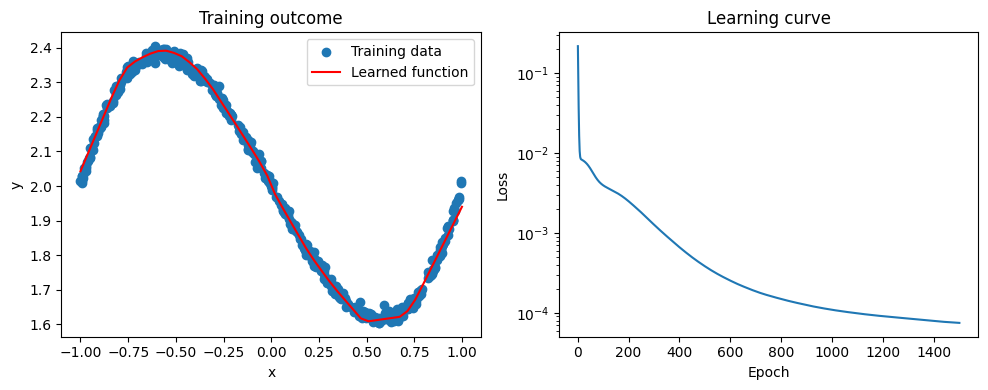

In [41]:
def train_and_plot_myneuralnet(n_hidden: int, epochs: int, batch_size: int, learn_rate: float, N: int):
    """ Trains a MyNeuralNet with the specified parameters, and plots the learned function and the training curve
    
    Args:
        n_hidden: number of hidden neurons of the model
        epochs: the number of epochs, i.e., of complete passes over the data set
        batch_size: the batch size to use in minibatch gradient descent
        learn_rate: the learning rate to use in minibatch gradient descent
        N: the number of data points in the training set. The training data is generated by the function get_training_data_myneuralnet.
    """
    model = MyNeuralNet(n_hidden=n_hidden)
    losses = train_myneuralnet(model, epochs=epochs, batch_size=batch_size, learn_rate=learn_rate, N=N)
    X_train, y_train = next(get_training_data_myneuralnet(N, N))  # load the whole data set
    X_train = X_train.flatten()
    y_train = y_train.flatten()
    X_plot = np.linspace(-1, 1)
    y_plot = model.forward(X_plot.reshape(-1, 1)).flatten()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    ax1.scatter(X_train, y_train, label='Training data')
    ax1.plot(X_plot, y_plot, label='Learned function', color='red')
    ax1.legend(loc='best')
    ax1.set_title('Training outcome')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax2.semilogy(np.arange(epochs)+1, losses)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Learning curve')
    plt.show()

train_and_plot_myneuralnet(n_hidden=200, epochs=1500, batch_size=4, learn_rate=0.01, N=500)

## Convolutions
__Question 1.6__ Implement the function `add_padding`.

In [42]:
def add_padding(image: np.ndarray, P: int) -> np.ndarray:
    """ Adds padding to a batch of images.
        
    The padding valu should be 0. Padding images should not change the number of channels or the batch size.
    
    Args:
        image: Batch of images as a numpy array of shape (batch_size, height, width, n_channels).
        P: Number of zeros to add at all four sides of each image.
        
    Returns:
        The padded image as a numpy array of shape (batch_size, height + 2P, width + 2P, n_channels).
    """
    return np.pad(image, ((0, 0), (P, P), (P, P), (0, 0)), mode='constant', constant_values=0)

Run the following cell to make sure your implementation outputs the correct shape, uses the correct padding value of 0, and works correctly if `P=1`.

In [43]:
__batch_size = 5
__height = 16
__width = 26
__n_channels = 3
__padding = 2
__images = np.random.randn(__batch_size, __height, __width, __n_channels)
__padded_images = add_padding(__images, __padding)

__target_shape = (__batch_size, __height + 2 * __padding, __width + 2 * __padding, __n_channels)
assert __padded_images.shape == __target_shape, f"For a batch of {__batch_size} images of height {__height} and width {__width} with {__n_channels} channels, the padded image batch should have shape {__target_shape}, but had shape {__padded_images.shape}"

__padded_images[:, __padding:-__padding, __padding:-__padding, :] = 0
assert np.allclose(__padded_images, 0), "The values added by the padding should all be 0."

assert np.all(__images == add_padding(__images, 0)), "If P=0, the padding function should not change the input batch, but your implementation did."

clear_output()
CHECKS_PASSED_MESSAGE

'Great! All checks were passed.'

In [44]:
# This cell is used for grading. Do not remove. Do not change.

__Question 1.7__ Implement the function `convolve`. We have already given you some code to start with. Particularly, `F_out` should be the number of channels your convolution outputs, `h_out` should be the height of the images your convolution outputs, and `w_out` should be the width of the images that your convolution outputs. You only have to fill in the part of the code that performs the actual convolution of the input image batch.

In [45]:
def convolve(kernels: np.ndarray, images: np.ndarray, stride: int) -> np.ndarray:
    """ Computes the convolution of a given batch of images with given kernels and a given stride.
    
    You should assume that the given images are already properly padded.
    
    Args:
        kernels: The kernels as a numpy array of shape (K, K, F_in, F_out).
        images: The batch matrix containing the images as a numpy array of shape (batch_size, h_in, w_in, F_in).
        stride: The positive stride.
    
    Returns:
        The convolved batch of images as a numpy array of shape (batch_size, h_out, w_out, F_out).
    """
    batch_size, h_in, w_in, F_in = images.shape  # extract shape information
    F_out = kernels.shape[3]  # number of output channels of the kernels
    K = kernels.shape[0]  # size of the kernels
    
    # make sure the number of input channels matches
    assert F_in == kernels.shape[2], f"Size mismatch: images and kernels have different number of input filters ({F_in} != {kernels.shape[2]})."
    
    # make sure every kernel is square
    assert kernels.shape[0] == kernels.shape[1], "Every kernel must be a square matrix."
    
    h_out = (h_in - K) / stride + 1  # target height of the convolved output
    w_out = (w_in - K) / stride + 1  # target width of the convolved output
    
    # make sure that height and width are integers (i.e., that the kernels "fit" the image in size)
    assert int(h_out) == h_out and int(w_out) == w_out, "Incompatible dimensions."
    h_out = int(h_out)  # cast height from float to int
    w_out = int(w_out)  # cast width from float to int
    
    # YOUR CODE HERE
    assert int(h_out) == h_out and int(w_out) == w_out, "Incompatible dimensions."
    
    output = np.zeros((batch_size, h_out, w_out, F_out))
    
    for b in range(batch_size):
        for i in range(0, h_out * stride, stride):
            for j in range(0, w_out * stride, stride):
                for f in range(F_out):
                    region = images[b, i:i+K, j:j+K, :]
                    output[b, i//stride, j//stride, f] = np.sum(region * kernels[:, :, :, f])
    
    return output

Run the following cell to make sure that your convolution produces the correct shape on a simple example.

In [46]:
__kernel_size = 2
__f_out = 4
__stride = 2
__h_in = 4
__w_in = 6
__kernels = np.linspace(0, 1, __kernel_size * __kernel_size * 3 * __f_out).reshape(__kernel_size, __kernel_size, 3, __f_out)  # 4 kernels of shape (2, 2, 3)
__images = np.linspace(0, 10, 2 * 4 * 6 * 3).reshape(2, __h_in, __w_in, 3)  # 2 images of size 4x6 with 3 filters
__batch_size = __images.shape[0]
__output = convolve(__kernels, __images, __stride)

__target_shape = (__batch_size, (__h_in - __kernel_size) // __stride + 1, (__w_in - __kernel_size) // __stride + 1, __f_out)
assert __output.shape == __target_shape, f"The output of your convolution should be of shape {__target_shape} for a batch of {__batch_size} {__images.shape[1:]} images and a stride of {__stride}, but was {__output.shape}."

clear_output()
CHECKS_PASSED_MESSAGE

'Great! All checks were passed.'

__Question 1.8__ Perform sharpening, edge detection, and blurring of the given example image. Here you simply have to run the cell below.

In [ ]:
import matplotlib.image as mpimg

EXAMPLE_KERNELS = np.dstack((
    np.array([ [0, 0, 0], [0, 1, 0], [0, 0, 0] ]),
    np.array([ [0, -1, 0], [-1, 5, -1], [0, -1, 0] ]),
    np.array([ [1, 0, -1], [0, 0, 0], [-1, 0, 1] ]), 
    np.array([ [0, 1, 0], [1, -4, 1], [0, 1, 0] ]),
    np.array([ [-1, -1, -1], [-1, 8, -1], [-1, -1, -1] ]),
    np.array([ [1, 2, 1], [2, 4, 2], [1, 2, 1] ]) / 16
))


def filter_example():
    example_img = mpimg.imread(EXAMPLE_IMAGE)
    plt.imshow(example_img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Example Image')
    
    # Add a batch dimension to match with our requirements
    example_img = example_img[np.newaxis, :, :, :]
    filtered_images = np.zeros((EXAMPLE_KERNELS.shape[2], *example_img.shape[1:]), dtype=float)
    example_img = np.pad(example_img.copy(), [(0, 0), (1, 1), (1, 1), (0, 0)])
    
    for b in range(filtered_images.shape[0]):
        inactive = np.zeros((3, 3), dtype=float)
        active = EXAMPLE_KERNELS[:, :, b]
        red = np.dstack((active, inactive, inactive))
        green = np.dstack((inactive, active, inactive))
        blue = np.dstack((inactive, inactive, active))
        total = np.stack((red, green, blue), axis=3)
        filtered_images[b, :, :, :] = convolve(total, example_img, 1)[0, :, :, :]
    # The convolution operation puts some values outside of the range [0, 1], so we clip them
    filtered_images = np.clip(filtered_images, 0, 1)
    # You may need to re-order this list to have the correct titles
    names = ['Identity', 'Sharpening', 'Edge detection 1', 'Edge detection 2', 'Edge detection 3', 'Gaussian blur 3x3']
    fig, axs = plt.subplots(2, 3, figsize=(11,7), constrained_layout=True)
    # plt.subplots_adjust(wspace=0.1, hspace=0.01)

    for b in range(filtered_images.shape[0]):
        fil = filtered_images[b, :, :, :]
        i = b // 3
        j = b % 3
        axs[i, j].imshow(fil)
        axs[i, j].set_title(names[b])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    plt.show()

filter_example()

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

## Convolutions in PyTorch

In [ ]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch import Tensor

torch.manual_seed(1234)
torch.set_default_dtype(torch.float32)

Run the following cell to load the data from the `DATA` directory. Here you don't have to implement anything.

In [ ]:
IMG_SIZE = 224

transformations = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
])

train_valid_ds = ImageFolder(
    root=str(DATA/"train"),
    transform=transformations
)

train_valid_size = len(train_valid_ds)
train_size = int(0.7 * train_valid_size)
valid_size = train_valid_size - train_size

train_ds, valid_ds = random_split(train_valid_ds, [train_size, valid_size])

test_ds = ImageFolder(
    root=str(DATA/"test"),
    transform=transformations
)

__Question 2.1__ Implement the `SimpLeNet` Neural Network as stated in the assignment PDF. In the `__init__` method, you should initialise all the `torch` modules that you need for the model. The `forward` method should perform a forward pass through the complete model.

In [ ]:
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU, Sigmoid


class SimpLeNet(torch.nn.Module):
    def __init__(self):
        """ Initialized the neural network.
        
        Here, you define all the necessary layers that are subsequently used in the forward pass.
        Hint: Take a look at the imports above.
        """
        super().__init__()
        self.conv = ...
        self.pool = ...
        self.flatten = ...
        self.ff1 = ...
        self.relu = ...
        self.ff2 = ...
        self.sigmoid = ...
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def forward(self, x: Tensor) -> Tensor:
        """ Performs a forward pass through the entire network.
        
        Args:
            x: Input batch matrix as a pytorch tensor of shape (batch_size, 224, 224, 3).
            
        Returns:
            The output as a pytorch tensor of shape (batch_size, 1).
        """
        # YOUR CODE HERE
        raise NotImplementedError()

Run the following cell to make sure a forward pass through your model produces the correct output shape.

In [ ]:
__sample, _ = train_ds[0]
__my_neural_network = SimpLeNet()
__sample_batch = __sample.unsqueeze(0)

__output =__my_neural_network(__sample_batch)
__target_output_shape = (1, 1)
assert __output.shape == __target_output_shape, f"Your neural network receives an input of shape {tuple(__sample_batch.shape)} and should return an output of shape {__target_output_shape}, but output was of shape {tuple(__output.shape)}."

clear_output()
CHECKS_PASSED_MESSAGE

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

__Question 2.2__ Implement the function `train` that trains a given `model` for a given number of `epochs` using a given `batch_size` and `learning_rate`. We already implemented part of the code for you. You should use the `criterion` to compute the loss of a batch of predictions and targets. You should use the `optimizer` to perform the actual gradient descent. The `train_loader` already holds all input batches. The missing part that you have to implement is to make predictions for the `inputs`, calculate the loss given these predictions and the `labels`, backpropagate the loss, and perform an optimization step.

In [ ]:
from tqdm.notebook import tqdm


def train(model, batch_size, epochs, learning_rate):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:  # loop over the dataset multiple times
            running_loss = 0.0
            samples_in_epoch = 0
            
            with tqdm(train_loader) as ebar:
                for inputs, labels in ebar:
                    optimizer.zero_grad()  # reset the parameter gradients to 0
                    labels = labels.float()  # cast label type to float
                    # forward + backward + optimize
                    # YOUR CODE HERE
                    raise NotImplementedError()
                    running_loss += loss.item() * inputs.shape[0]  # keep track of current loss
                    samples_in_epoch += inputs.shape[0]
                    ebar.set_description(f"Epoch {epoch+1} | Loss {running_loss/samples_in_epoch:0.04f}")
                losses.append(running_loss / len(train_ds))  # compute and store average loss during the epoch
                
            pbar.set_description(f"Total Training | Loss {losses[-1]:.04f}")  # show loss during the last epoch
    
    return losses

__Question 2.3__ Run the following cell to train your model. Note that this might take some time.

In [ ]:
__model = SimpLeNet()
__epochs = 5
__learning_rate = 0.01
__batch_size = 128

losses = train(__model, __batch_size, __epochs, __learning_rate)

Run the following cell to evaluate the accuracy of the model on the validation dataset.

In [ ]:
def evaluate(model)-> float:
    validation_loader = DataLoader(valid_ds)
    correct_classifications = 0
    
    for inputs, labels in validation_loader:
        labels = labels.float()  # cast label type to float
        predictions = model(inputs).squeeze(-1) >= 0.5  # map probabilities to binary classifications
        correct_classifications += torch.sum(predictions.int() == labels)  # count number of correct classifications

    return correct_classifications / len(valid_ds)
        
accuracy = evaluate(__model)
print(f"The model achieved an accuracy of {100 * accuracy:.2f}% on the validation dataset.")

# Extending Pretrained Models
__Question 3.1__ Implement the `AdaptedResNet` Neural Network. In the constructor (`__init__`), make sure that only gradients of the `classifier` are tracked by PyTorch and that gradients of the ResNet module are not being tracked. Additionally, implement the `forward` function of the neural network.

In [ ]:
from torchvision import models

class AdaptedResNet(torch.nn.Module):
    def __init__(self):
        """ Initializes the module.
        
        We load the ResNet module, select the layers that we are interested in and set ResNet to evaluation mode as we 
        don't plan on training the ResNet part of the model.
        Additionally, we define a custom classifier that works with the representations obtained from the ResNet model.
        
        Here, your task is to make sure that PyTorch doesn't track the gradients of the ResNet model which would add
        a lot of computational overhead which is not necessary as we don't want to train the ResNet model anyway. For this,
        each PyTorch module already implements the function requires_grad_(...) which you can use
        to prevent PyTorch from tracking gradients for specific modules.
        """
        super().__init__()

        # load pre-trained ResNet model from checkpoint
        # normally, you would need to specify arguments in models.resnet18 to specify which weights you want to load
        # here, we have already downloaded the weights for you
        resnet = models.resnet18()
        weights = torch.load(DATA / "resnet18_weights.pth", weights_only=True)
        resnet.load_state_dict(weights)
        
        # use ResNet without the last feed-forward layer as backbone model
        self.backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.backbone.eval()  # deactivate the dropout layers of ResNet

        # add a custom classification step
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )
        
        # Do not change what precedes
        
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def forward(self, x: Tensor) -> Tensor:
        """ Performs a forward pass through the neural network.
        
        First, use the ResNet network to obtain an expressive latent representation of the image.
        Then, use the custom classifier to make an actual prediction about the input.
        
        Args:
            x: Batch of input images as a pytorch tensor of shape (batch_size, 3, 224, 224).
            
        Returns:
            A batch of predictions as a pytorch tensor of shape (batch_size, 1).
        """
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def train(self, mode=True):
        """ Sets the module in training mode and ensures that ResNet remains in eval mode.
        """
        super().train(mode)
        self.backbone.eval()

Run the following cell to make sure you output the right parameters.

In [ ]:
__model = AdaptedResNet()
__parameters = __model.parameters()
__n_parameters = sum(parameter.numel() for parameter in __parameters if parameter.requires_grad)
__target_n_parameters = 8225

assert __n_parameters == __target_n_parameters, f"The classifier has {__target_n_parameters} parameters, but your model has {__n_parameters} trainable parameters. Hint: Use the .requires_grad_(False) method of the ResNet module to stop tracking gradients of the ResNet module."

clear_output()
CHECKS_PASSED_MESSAGE

Run the following cell to make sure the output of the network has the expected properties.

In [ ]:
__model = AdaptedResNet()
__batch_size = 16
__random_batch = torch.rand(__batch_size, 3, IMG_SIZE, IMG_SIZE)
__predictions = __model(__random_batch)

__target_shape = (__batch_size, 1)
assert __predictions.shape == __target_shape, f"The output of your model should have shape {__target_shape}, but your returned a tensor of shape {tuple(__predictions.shape)}."
assert torch.all(__predictions >= 0), "The output of your model should be probabilities, but you returned values smaller than 0."
assert torch.all(__predictions <= 1), "The output of your model should be probabilities, but you returned values bigger than 1."

clear_output()
CHECKS_PASSED_MESSAGE

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

__Question 3.2__ Implement the function `early_stopping_check` that decided whether to stop the training based on the loss history.

In [ ]:
def early_stopping_check(losses: list[float], threshold: int) -> bool:
    """ Checks whether to stop early during training.
    The check should decide to stop early if and only if a certain theshold of losses have been monotonoically increasing.
    
    Args:
        losses: List of scalar losses for each epoch. For each epoch there is exactly one loss. losses[0] corresponds to the first epoch. losses[-1] corresponds to the last epoch.
        threshold: Number of latest losses to be monotonically increasing for the training to stop early.
        
    Returns:
        True if the training should be stopped and otherwise False.
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

__Question 3.3__ Implement the `forward` pass of the `DropoutAdaptedResNet` Neural Network. The model should behave just like the `AdaptedResNet`, but should randomly set $20\%$ of the representation between the ResNet output and the custom classifier to $0$.

In [ ]:
from torch.nn.functional import dropout


class DropoutAdaptedResNet(AdaptedResNet):
    def __init__(self):
        super().__init__()
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def forward(self, x: Tensor) -> Tensor:
        # YOUR CODE HERE
        raise NotImplementedError()
        return x

In [ ]:
__model = DropoutAdaptedResNet()
assert isinstance(__model, AdaptedResNet), "Your model should extend the `AdaptedResNet` model. You are not allowed to change the class signature."
assert hasattr(__model, "backbone"), "Your model should contain a module called `bachbone`. You are not allowed to change attribute names."
assert hasattr(__model, "classifier"), "Your model should contain a module called `classifier`. You are not allowed to change attribute names."

clear_output()
CHECKS_PASSED_MESSAGE

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

__Question 3.4__ Implement the function `store_checkpoint`.

In [ ]:
CHECKPOINT_DIR = ROOT / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True, parents=False)

def store_checkpoint(model: torch.nn.Module, epoch: int) -> None:
    """ Saves the state of a model to disk.
    
    Specifically, the model should be saved in a .pt file in the CHECKPOINT_DIR folder.
    The file name of the model should be `model-{epoch}`.
    
    Args:
        model: Module to be saved to disk.
        epoch: Epoch at which the model was saved.
        
    Returns:
        Nothing.
    """    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
__model = DropoutAdaptedResNet()
__checkpoint_path = CHECKPOINT_DIR / "model-0.pt"
store_checkpoint(__model, 0)
__loaded_model = torch.load(__checkpoint_path)
assert hasattr(__loaded_model, "parameters"), "Make sure the checkpoint exposes the parameters of the model directly. Do not use the state dict."

clear_output()
CHECKS_PASSED_MESSAGE

In [ ]:
# This cell is used for grading. Do not remove. Do not change.

__Question 3.5__ Implement the remaining part of the training loop just as you did in Question 2.2. Here you just have to fill in the missing part in the inner `for` loop.

In [ ]:
from tqdm.notebook import tqdm

def transfer_train(model: torch.nn.Module, batch_size: int, epochs: int, learning_rate: float) -> list[float]:
    assert "store_checkpoint" in globals(), "The store_checkpoint function is not defined."
    assert "early_stopping_check" in globals(), "The early_stopping_check function is not defined."
    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size)
    
    losses = []
    valid_losses = []
    
    CHECKPOINT_DIR.mkdir(exist_ok=True, parents=False)
    store_checkpoint(model, 0)
    
    with tqdm(range(1, epochs + 1)) as pbar:
        for epoch in pbar:  # loop over the dataset multiple times
            running_loss = 0.0
            samples_in_epoch = 0
            with tqdm(train_loader) as ebar:
                for i, (inputs, labels) in enumerate(ebar):
                    optimizer.zero_grad()  # reset the parameter gradients to 0
                    labels = labels.float()  # cast label type to float
                    # forward + backward + optimize
                    # YOUR CODE HERE
                    raise NotImplementedError()

                    running_loss += loss.item() * inputs.shape[0]  # keep track of current loss
                    samples_in_epoch += inputs.shape[0]
                    ebar.set_description(f"Epoch {epoch} | Loss {running_loss/samples_in_epoch:0.04f}")
                
            losses.append(running_loss / len(train_ds))
            pbar.set_description(f"Total training | Loss {losses[-1]:.02f}")
            
            running_loss = 0.0
            samples_in_epoch = 0
                
            with tqdm(valid_loader) as ebar:
                for inputs, labels in ebar:
                    labels = labels.float()  # cast label type to float
                    predictions = model(inputs).squeeze(-1)
                    loss = criterion(predictions, labels)
                    
                    running_loss += loss.item() * inputs.shape[0]  # keep track of current loss
                    samples_in_epoch += inputs.shape[0]
                    ebar.set_description(f"Epoch {epoch} | Validation Loss {running_loss/samples_in_epoch:0.04f}")
            
            valid_losses.append(running_loss / len(valid_ds))
            
            store_checkpoint(model, epoch)
            
            if early_stopping_check(valid_losses, 3):
                break
    return losses, valid_losses

Run the following cell to fine-tune your model. Note that this might take some time.

In [ ]:
import random
np.random.seed(1)
random.seed(2)
torch.manual_seed(3)


__model = DropoutAdaptedResNet()
__batch_size = 32
__epochs = 3
__learning_rate = 0.001

__model.train()  # set model in training mode
losses, valid_losses = transfer_train(__model, __batch_size, __epochs, __learning_rate)  # train the model and store loss history

clear_output()

In [ ]:
# plot loss history
def plot_history():
    epochs_axis = range(1, len(losses) + 1)
    plt.plot(epochs_axis, losses, "b", label="Training loss")
    plt.plot(epochs_axis, valid_losses, "r", label="Validation loss")
    plt.legend(loc="upper right")
    plt.title("Loss throughout training")
    
plot_history()

__Optional Question 3.6__ Implement the function `evaluate_accuracy` that computes the proportion of correctly classified data points in the test data set. The `test_loader` already hold the test data to be iterated over. You only have to implement the remaining part of the code that makes a prediction for each `input` and updates the number of correctly classified inputs.

In [ ]:
def evaluate_accuracy(model: torch.nn.Module) -> float:
    test_loader = DataLoader(test_ds)
    n_correct = 0
    
    # count the number of correct classifications
    for inputs, labels in tqdm(test_loader):
        # YOUR CODE HERE
        raise NotImplementedError()
    
    return n_correct / len(test_ds)

Run the following cell to compute the accuracy of your model.

In [ ]:
accuracy = evaluate_accuracy(__model)
print(f"Your model achieves an accuracy of {100 * accuracy:.2f}% on the test dataset.")